### NivLink Demo: Multidimensional Decision-Making Task

This demo uses data from a multidimensional decision-making paradigm similar to the one described in: 

> Leong, Y. C., Radulescu, A., Daniel, R., Dewoskin, V., Niv, Y. (2017). Dynamic Interaction between Reinforcement Learning and Attention in Multidimensional Environments. _Neuron_, 93(2), 451–463. http://doi.org/10.1016/j.neuron.2016.12.040

On every trial of the task, participants choose between three column stimuli which vary along three dimensions: faces, houses and tools. Upon choosing a column, they either receive a reward or not, presented as a green or red rectangle around the chosen column. After a variable delay, the features in each column reshuffle along each dimension, and the next trial begins.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
import pandas as pd
import matplotlib.pyplot as plt
from nivlink import ScreenInfo
from nivlink import epoching_fht, align_to_aoi, compute_fixations, map_to_feats

sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#### Load data.

Refer to [DataViewer documentation](https://github.com/nivlab/NivLink/blob/master/docs/DataViewer.Md) for details on how to generate raw text files for your experiment. 


In [2]:
## Load single subject data from text file.
et_data_path = 'single_subj_sample_data.txt'
raw_data = pd.read_table(et_data_path);

## Filter out columns of interest, convert to array and replace '.' with NaNs.
raw_data_lean = raw_data.filter(['SAMPLE_MESSAGE','RIGHT_GAZE_X','RIGHT_GAZE_Y'], axis=1)
raw_data_lean = raw_data_lean.replace('.',np.nan)
raw_data_array = raw_data_lean.values

#### Load pre-generated events file.

The events file is a 3-column `.mat` file with line per trial which defines:  

- The run number (here, "run" refers to a continuous chunk of time during which the eye-tracker was recording) 
- The trial onset relative to when the eye-tracker started recording on this run
- The trial duration

In [3]:
events_file_path = 'single_subj_sample_events.mat'
events_mat = io.loadmat(events_file_path)
events = np.array(events_mat["events_array"])

#### Load pre-generated feature map file.

The feature map file is a n_trial by n_aoi with one line per trial which defines the task feature corresponding to each AOI. 

In [4]:
featmap_file_path = 'single_subj_sample_featmap.mat'
featmap_mat = io.loadmat(featmap_file_path)
featmap = np.array(featmap_mat["features_aoi_map"])

#### Define screen parameters.

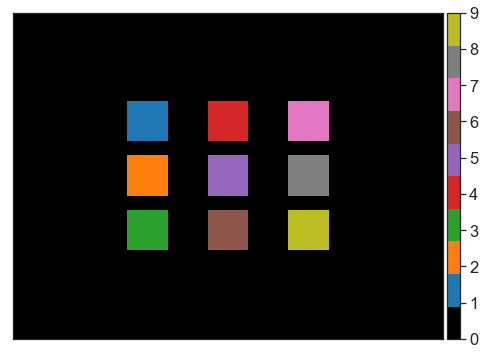

In [5]:
## Define metadata.
xdim, ydim, sfreq = 1600, 1200, 500

## Initialize ScreenInfo object.
info = ScreenInfo(xdim, ydim, sfreq)

## Define and add areas of interest.
n_aois = 9
aois = np.empty((n_aois,2,2))

# Left column
aois[0] = np.matrix([[425, 325], [575, 475]])
aois[1] = np.matrix([[425, 525], [575, 675]])
aois[2] = np.matrix([[425, 725], [575, 875]])

# Middle column
aois[3] = np.matrix([[725, 325], [875, 475]])
aois[4] = np.matrix([[725, 525], [875, 675]])
aois[5] = np.matrix([[725, 725], [875, 875]])

# Right column
aois[6] = np.matrix([[1025, 325], [1175, 475]])
aois[7] = np.matrix([[1025, 525], [1175, 675]])
aois[8] = np.matrix([[1025, 725], [1175, 875]])

for a in range(0, n_aois):
    info.add_rectangle_aoi(aois[a,0,0], aois[a,1,0], aois[a,0,1], aois[a,1,1])
    
## Visually inspect AOIs
fig, ax = info.plot_aoi(6,False,)
plt.show(fig)

#### Preprocess.

In [61]:
## Run epoching. 
epochs = epoching_fht(raw_data_array, info, events)

## Align to AOI.
aligned = align_to_aoi(epochs, info)

## Compute fixations. 
fixations = compute_fixations(aligned, info)

## Map to task features. 
fixations['Feature'] = featmap[fixations.Trial.values.astype(int) - 1,fixations.AoI.values.astype(int) - 1]
print(fixations.head(20))

    Trial  AoI  Onset  Offset  Duration  Feature
0     1.0  1.0  0.408   0.610     0.202      8.0
1     1.0  5.0  0.824   1.192     0.368      4.0
2     1.0  8.0  1.208   1.438     0.230      5.0
3     1.0  8.0  1.624   1.954     0.330      5.0
4     1.0  5.0  1.970   4.000     2.030      4.0
5     2.0  5.0  0.000   0.648     0.648      6.0
6     2.0  2.0  0.662   0.854     0.192      5.0
7     2.0  5.0  0.868   0.868     0.000      6.0
8     2.0  5.0  1.246   2.616     1.370      6.0
9     2.0  8.0  2.632   2.972     0.340      4.0
10    2.0  5.0  2.986   2.994     0.008      6.0
11    2.0  2.0  3.008   3.442     0.434      5.0
12    2.0  5.0  3.452   3.458     0.006      6.0
13    2.0  8.0  3.470   3.680     0.210      4.0
14    2.0  7.0  3.688   3.874     0.186      7.0
15    2.0  4.0  3.888   4.000     0.112      8.0
16    3.0  5.0  0.000   0.362     0.362      6.0
17    3.0  2.0  0.382   1.172     0.790      5.0
18    3.0  1.0  1.194   1.316     0.122      9.0
19    3.0  8.0  1.35

#### Run some basic QA checks.

Text(0.5,1,'Distribution of fixations per trial')

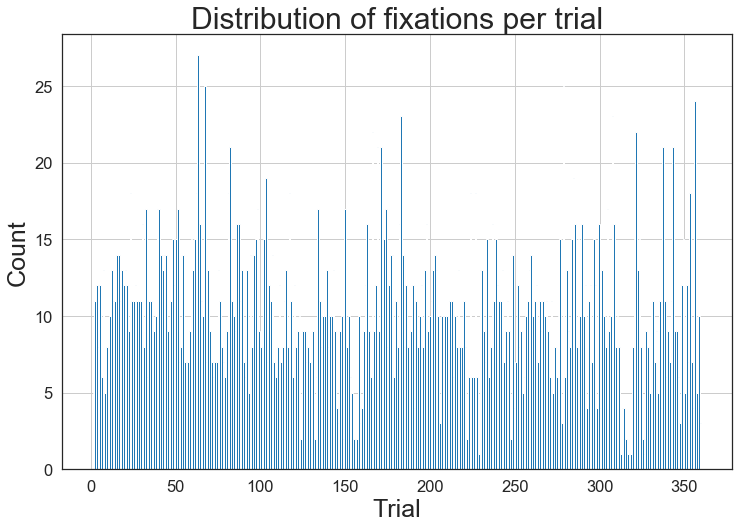

In [7]:
fixations.hist('Trial',bins=360,figsize=[12,8])
plt.xlabel('Trial',fontsize=25)
plt.ylabel('Count',fontsize=25)
plt.title('Distribution of fixations per trial',fontsize=30)

Text(0.5,1,'Distribution of AoIs')

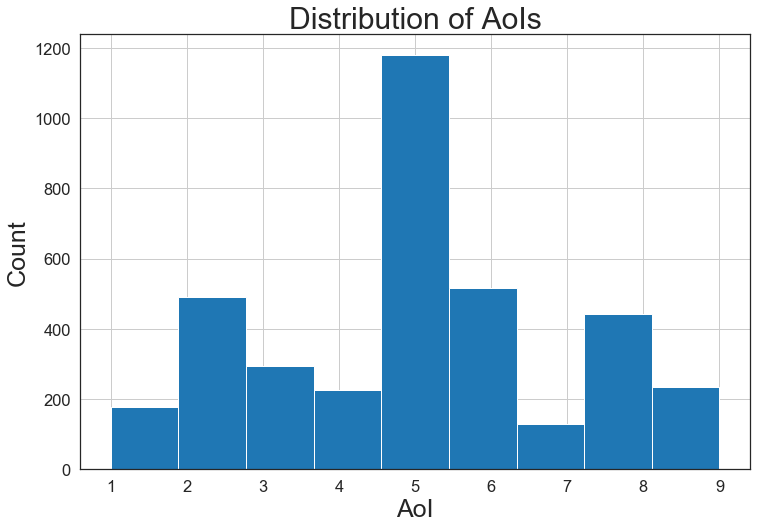

In [16]:
fixations.hist('AoI',bins=9,figsize=[12,8])
plt.xlabel('AoI',fontsize=25)
plt.ylabel('Count',fontsize=25)
plt.title('Distribution of AoIs',fontsize=30)

Text(0.5,1,'Distribution of Features')

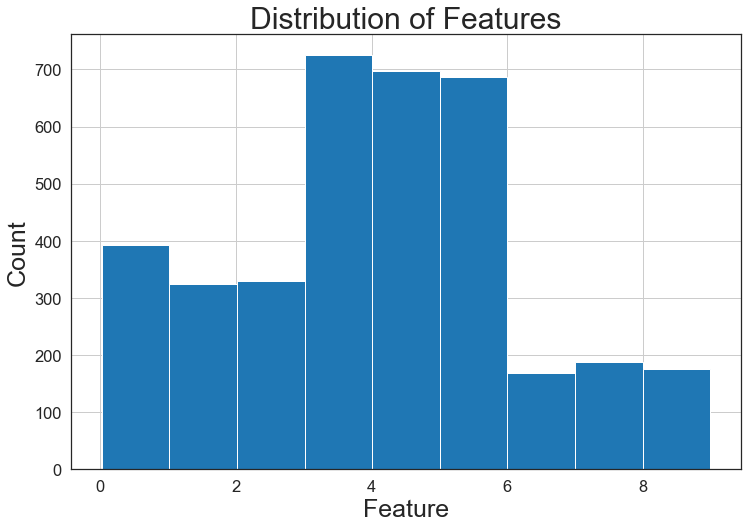

In [10]:
fixations.hist('Feature',bins=9,figsize=[12,8])
plt.xlabel('Feature',fontsize=25)
plt.ylabel('Count',fontsize=25)
plt.title('Distribution of Features',fontsize=30)